Epoch 1/200


C:\Users\tk\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step - loss: 0.1937 - val_loss: 0.0084
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - loss: 0.0259 - val_loss: 0.0074
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - loss: 0.0111 - val_loss: 0.0052
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - loss: 0.0110 - val_loss: 0.0012
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - loss: 0.0061 - val_loss: 0.0020
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - loss: 0.0056 - val_loss: 2.9424e-04
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - loss: 0.0048 - val_loss: 9.4292e-04
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - loss: 0.0043 - val_loss: 3.3375e-04
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - loss: 0.0036 - val_loss: 2.5712e-04
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - loss: 0.0032 - val_loss: 2.0261e-04
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - loss: 0.0035 - val_loss: 2.6251e-04
Epoch 12/200
16/16 ━━━━━━━━━━

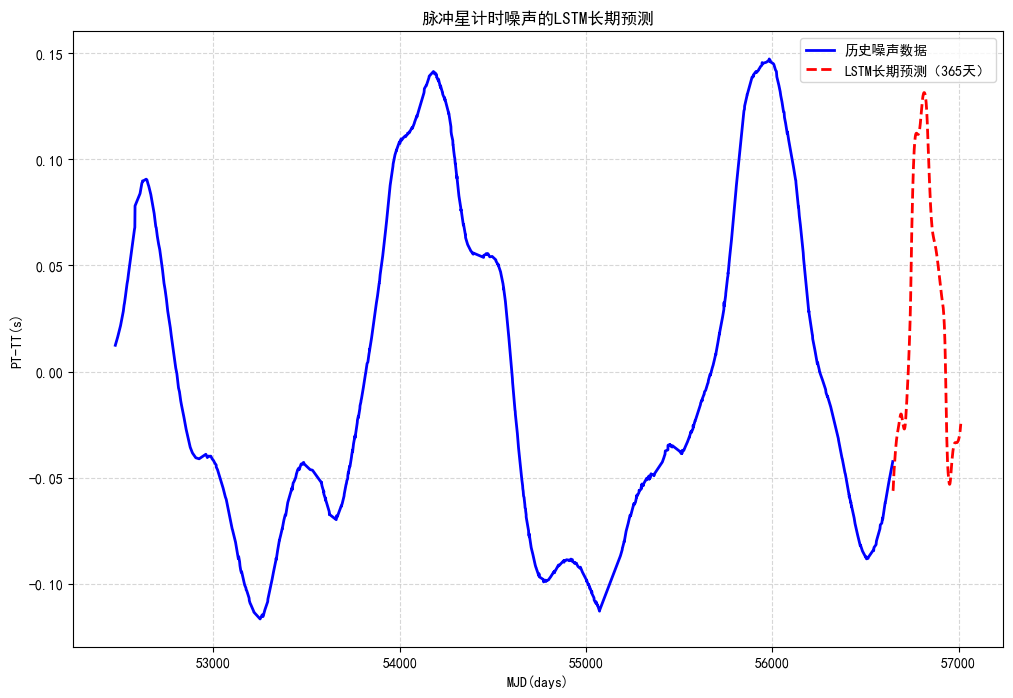

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 设置matplotlib使用支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体显示中文
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 加载数据
data = pd.read_excel('Attachment 1.xlsx')
data.columns = ['MJD(days)', 'PT-TT(s)']

# 设置MJD(days)为索引
data.set_index(keys='MJD(days)', inplace=True)

# 清理数据，将非数值转换为NaN并删除
data['PT-TT(s)'] = pd.to_numeric(data['PT-TT(s)'], errors='coerce')
data = data.dropna()

# 数据标准化
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data['PT-TT(s)'].values.reshape(-1, 1))

# 准备LSTM的输入数据
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

# 增加序列长度以捕捉更长期的模式
seq_length = 100  # 从30增加到90天
X, y = create_sequences(scaled_data, seq_length)

# 划分训练集和测试集
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 重塑数据以适应LSTM输入格式 [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# 构建更复杂的双向LSTM模型
model = Sequential([
    Bidirectional(LSTM(200, activation='relu', return_sequences=True), input_shape=(seq_length, 1)),
    Dropout(0.3),
    Bidirectional(LSTM(150, activation='relu', return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(100, activation='relu')),
    Dropout(0.3),
    Dense(50, activation='relu'),
    Dense(1)
])

# 编译模型，使用更小的学习率以提高稳定性
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

# 训练模型，增加epochs
history = model.fit(X_train, y_train, epochs=200, batch_size=32, 
                   validation_split=0.1, verbose=1)

# 预测未来365天
last_sequence = scaled_data[-seq_length:]
predictions = []

for _ in range(365):
    # 重塑数据用于预测
    current_sequence = last_sequence.reshape(1, seq_length, 1)
    # 预测下一个值
    next_pred = model.predict(current_sequence, verbose=0)[0]
    # 确保预测值在[0,1]范围内
    next_pred = np.clip(next_pred, 0, 1)
    # 添加预测值到列表
    predictions.append(next_pred[0])
    # 更新序列
    last_sequence = np.append(last_sequence[1:], next_pred)

# 反向转换预测值
predictions = np.array(predictions).reshape(-1, 1)
predictions = np.clip(predictions, 0, 1)  # 再次确保所有值都在[0,1]范围内
predictions = scaler.inverse_transform(predictions)

# 创建预测索引
forecast_index = data.index[-1] + np.arange(1, 366)

# 保存预测结果
forecast_df = pd.DataFrame({
    'MJD(days)': forecast_index,
    'Predicted PT-TT(s)': predictions.flatten()
})
forecast_df.to_csv('LSTM长期预测结果.csv', index=False, encoding='utf-8-sig')

# 绘制结果
plt.figure(figsize=(12, 8))
plt.plot(data['PT-TT(s)'], label='历史噪声数据', color='blue', linewidth=2)
plt.plot(forecast_index, predictions, label='LSTM长期预测（365天）', color='red', linestyle='--', linewidth=2)
plt.xlabel('MJD(days)')
plt.ylabel('PT-TT(s)')
plt.title('脉冲星计时噪声的LSTM长期预测')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Epoch 1/200


C:\Users\tk\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 205ms/step - loss: 0.1928 - val_loss: 0.0093
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - loss: 0.0261 - val_loss: 0.0120
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - loss: 0.0136 - val_loss: 0.0031
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - loss: 0.0078 - val_loss: 0.0036
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - loss: 0.0074 - val_loss: 8.7044e-04
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - loss: 0.0050 - val_loss: 4.6630e-04
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - loss: 0.0044 - val_loss: 3.5579e-04
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - loss: 0.0041 - val_loss: 9.9874e-04
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - loss: 0.0041 - val_loss: 7.0431e-04
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step - loss: 0.0038 - val_loss: 8.7314e-04
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 12/200
16/16 ━━━━━━━━━━

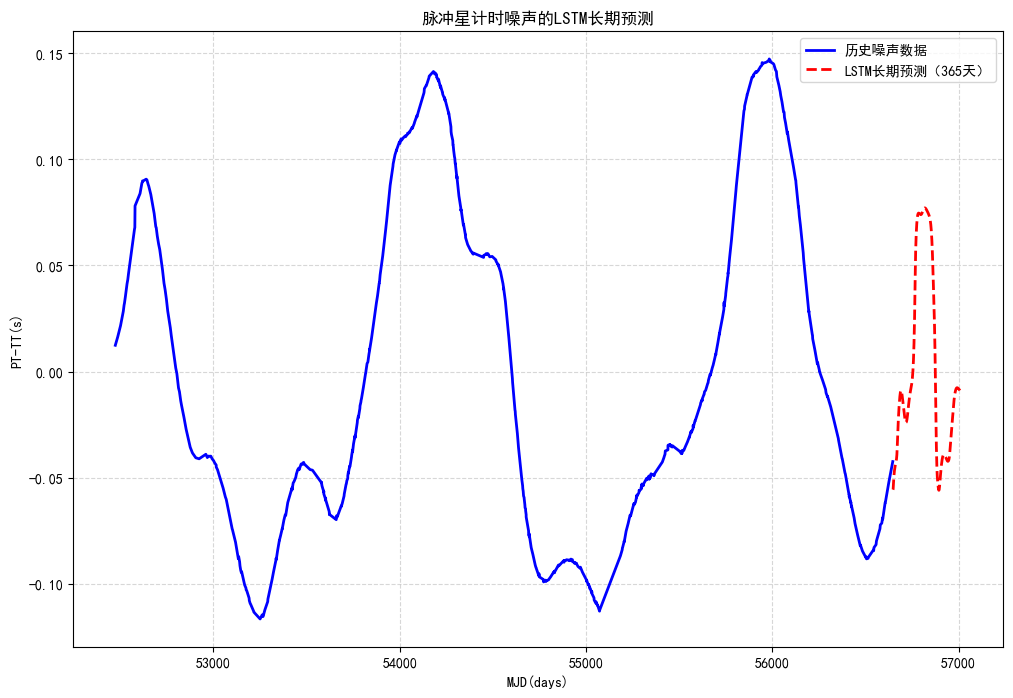

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 设置matplotlib使用支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体显示中文
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 加载数据
data = pd.read_excel('Attachment 1.xlsx')
data.columns = ['MJD(days)', 'PT-TT(s)']

# 设置MJD(days)为索引
data.set_index(keys='MJD(days)', inplace=True)

# 清理数据，将非数值转换为NaN并删除
data['PT-TT(s)'] = pd.to_numeric(data['PT-TT(s)'], errors='coerce')
data = data.dropna()

# 数据标准化
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data['PT-TT(s)'].values.reshape(-1, 1))

# 准备LSTM的输入数据
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

# 增加序列长度以捕捉更长期的模式
seq_length = 100  # 从30增加到90天
X, y = create_sequences(scaled_data, seq_length)

# 划分训练集和测试集
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 重塑数据以适应LSTM输入格式 [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# 构建更复杂的双向LSTM模型
model = Sequential([
    Bidirectional(LSTM(200, activation='relu', return_sequences=True), input_shape=(seq_length, 1)),
    Dropout(0.3),
    Bidirectional(LSTM(150, activation='relu', return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(100, activation='relu')),
    Dropout(0.3),
    Dense(50, activation='relu'),
    Dense(1)
])

# 编译模型，使用更小的学习率以提高稳定性
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

# 训练模型，增加epochs
history = model.fit(X_train, y_train, epochs=300, batch_size=64, 
                   validation_split=0.1, verbose=1)

# 预测未来365天
last_sequence = scaled_data[-seq_length:]
predictions = []

for _ in range(365):
    # 重塑数据用于预测
    current_sequence = last_sequence.reshape(1, seq_length, 1)
    # 预测下一个值
    next_pred = model.predict(current_sequence, verbose=0)[0]
    # 确保预测值在[0,1]范围内
    next_pred = np.clip(next_pred, 0, 1)
    # 添加预测值到列表
    predictions.append(next_pred[0])
    # 更新序列
    last_sequence = np.append(last_sequence[1:], next_pred)

# 反向转换预测值
predictions = np.array(predictions).reshape(-1, 1)
predictions = np.clip(predictions, 0, 1)  # 再次确保所有值都在[0,1]范围内
predictions = scaler.inverse_transform(predictions)

# 创建预测索引
forecast_index = data.index[-1] + np.arange(1, 366)

# 保存预测结果
forecast_df = pd.DataFrame({
    'MJD(days)': forecast_index,
    'Predicted PT-TT(s)': predictions.flatten()
})
forecast_df.to_csv('LSTM长期预测结果.csv', index=False, encoding='utf-8-sig')

# 绘制结果
plt.figure(figsize=(12, 8))
plt.plot(data['PT-TT(s)'], label='历史噪声数据', color='blue', linewidth=2)
plt.plot(forecast_index, predictions, label='LSTM长期预测（365天）', color='red', linestyle='--', linewidth=2)
plt.xlabel('MJD(days)')
plt.ylabel('PT-TT(s)')
plt.title('脉冲星计时噪声的LSTM长期预测')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

No GPU found, using CPU instead
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


C:\Users\tk\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 353ms/step - loss: 0.2283 - val_loss: 0.0291
Epoch 2/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 269ms/step - loss: 0.0576 - val_loss: 0.0164
Epoch 3/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step - loss: 0.0299 - val_loss: 0.0018
Epoch 4/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 258ms/step - loss: 0.0155 - val_loss: 0.0108
Epoch 5/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 289ms/step - loss: 0.0095 - val_loss: 0.0126
Epoch 6/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 269ms/step - loss: 0.0091 - val_loss: 0.0036
Epoch 7/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 266ms/step - loss: 0.0071 - val_loss: 0.0033
Epoch 8/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 264ms/step - loss: 0.0048 - val_loss: 0.0017
Epoch 9/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 264ms/step - loss: 0.0051 - val_loss: 8.7204e-04
Epoch 10/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 266ms/step - loss: 0.0043 - val_loss: 4.0190e-04
Epoch 11/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 269ms/step - loss: 0.0050 - val_loss: 3.8378e-04
Epoch 12/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step

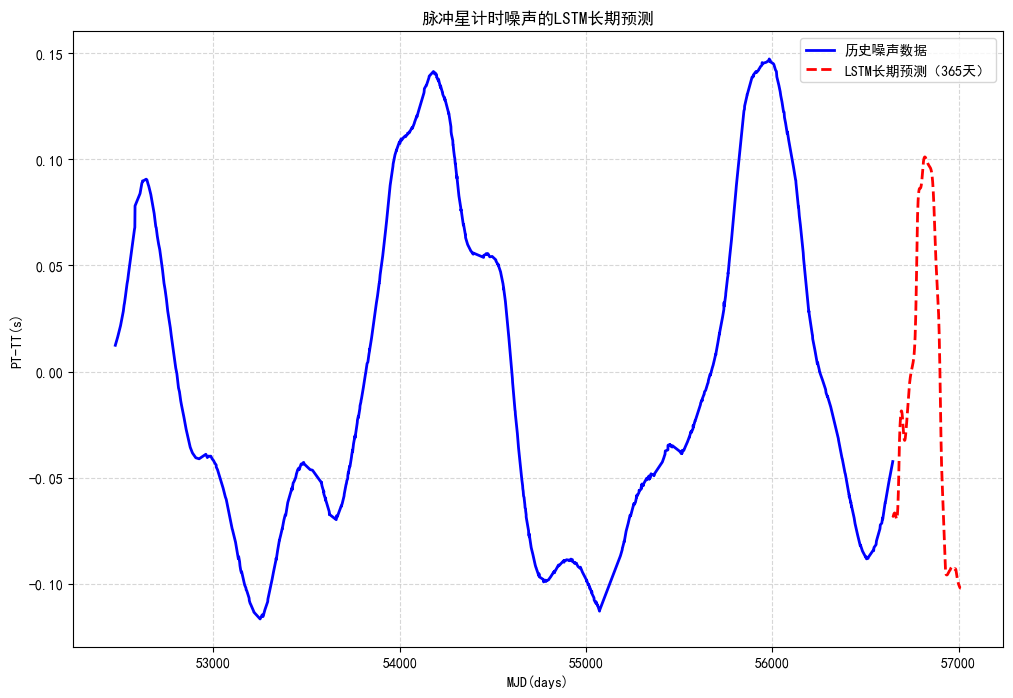

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 检查并设置GPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('GPU is available and will be used for training')
else:
    print('No GPU found, using CPU instead')

# 设置matplotlib使用支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体显示中文
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 加载数据
data = pd.read_excel('Attachment 1.xlsx')
data.columns = ['MJD(days)', 'PT-TT(s)']

# 设置MJD(days)为索引
data.set_index(keys='MJD(days)', inplace=True)

# 清理数据，将非数值转换为NaN并删除
data['PT-TT(s)'] = pd.to_numeric(data['PT-TT(s)'], errors='coerce')
data = data.dropna()

# 数据标准化
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data['PT-TT(s)'].values.reshape(-1, 1))

# 准备LSTM的输入数据
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

# 增加序列长度以捕捉更长期的模式
seq_length = 100  # 从30增加到90天
X, y = create_sequences(scaled_data, seq_length)

# 划分训练集和测试集
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 重塑数据以适应LSTM输入格式 [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# 使用GPU策略
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    # 构建更复杂的双向LSTM模型
    model = Sequential([
        Bidirectional(LSTM(200, activation='relu', return_sequences=True), input_shape=(seq_length, 1)),
        Dropout(0.3),
        Bidirectional(LSTM(150, activation='relu', return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(100, activation='relu')),
        Dropout(0.3),
        Dense(50, activation='relu'),
        Dense(1)
    ])

    # 编译模型，使用更小的学习率以提高稳定性
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

# 训练模型，增加epochs
history = model.fit(X_train, y_train, epochs=200, batch_size=64, 
                   validation_split=0.1, verbose=1)

# 预测未来365天
last_sequence = scaled_data[-seq_length:]
predictions = []

for _ in range(365):
    # 重塑数据用于预测
    current_sequence = last_sequence.reshape(1, seq_length, 1)
    # 预测下一个值
    next_pred = model.predict(current_sequence, verbose=0)[0]
    # 确保预测值在[0,1]范围内
    next_pred = np.clip(next_pred, 0, 1)
    # 添加预测值到列表
    predictions.append(next_pred[0])
    # 更新序列
    last_sequence = np.append(last_sequence[1:], next_pred)

# 反向转换预测值
predictions = np.array(predictions).reshape(-1, 1)
predictions = np.clip(predictions, 0, 1)  # 再次确保所有值都在[0,1]范围内
predictions = scaler.inverse_transform(predictions)

# 创建预测索引
forecast_index = data.index[-1] + np.arange(1, 366)

# 保存预测结果
forecast_df = pd.DataFrame({
    'MJD(days)': forecast_index,
    'Predicted PT-TT(s)': predictions.flatten()
})
forecast_df.to_csv('LSTM长期预测结果.csv', index=False, encoding='utf-8-sig')

# 绘制结果
plt.figure(figsize=(12, 8))
plt.plot(data['PT-TT(s)'], label='历史噪声数据', color='blue', linewidth=2)
plt.plot(forecast_index, predictions, label='LSTM长期预测（365天）', color='red', linestyle='--', linewidth=2)
plt.xlabel('MJD(days)')
plt.ylabel('PT-TT(s)')
plt.title('脉冲星计时噪声的LSTM长期预测')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [4]:
import torch

# 检查CUDA是否可用
print(torch.cuda.is_available())

# 打印CUDA版本
print(torch.version.cuda)

# 打印可用的GPU数量
print(torch.cuda.device_count())

# 打印第一个GPU的名称
print(torch.cuda.get_device_name(0))

False
None
0


AssertionError: Torch not compiled with CUDA enabled